# 2D Image Rotation Animation

This notebook demonstrates how to create an animation of a 2D image being rotated from 0 to 360 degrees using the Tensor Spline Interpolation, with each rotation performed on top of the last rotated image to observe error accumulation.

In [1]:
#!/usr/bin/env python3
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from scipy import ndimage, datasets
from IPython.display import HTML, display
from matplotlib import animation

from splineops.interpolate.tensorspline import TensorSpline

## Helper Functions

Define the helper functions to rotate an image and create the animation.

In [2]:
def rotate_image_splineops(image, angle, order=3, mode="zero"):
    """
    Rotate an image by a specified angle using SplineOps' TensorSpline method.

    Parameters:
    - image: The input image as a 2D numpy array.
    - angle: The rotation angle in degrees.
    - order: The order of the spline (0-7).
    - mode: The mode for handling boundaries (default is "zero").

    Returns:
    - Rotated image as a 2D numpy array.
    """
    dtype = image.dtype
    ny, nx = image.shape
    xx = np.linspace(0, nx - 1, nx, dtype=dtype)
    yy = np.linspace(0, ny - 1, ny, dtype=dtype)
    data = np.ascontiguousarray(image, dtype=dtype)

    rotated_image_cp = cp.asarray(data)
    xx_cp = cp.asarray(xx)
    yy_cp = cp.asarray(yy)

    order = max(0, min(order, 7))
    basis = f"bspline{order}"

    tensor_spline = TensorSpline(
        data=rotated_image_cp, coordinates=(yy_cp, xx_cp), bases=basis, modes=mode
    )
    angle_rad = np.radians(-angle)
    cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)
    original_center_x, original_center_y = (nx - 1) / 2.0, (ny - 1) / 2.0
    oy, ox = cp.ogrid[0:ny, 0:nx]
    ox = ox - original_center_x
    oy = oy - original_center_y

    nx_coords = cos_angle * ox + sin_angle * oy + original_center_x
    ny_coords = -sin_angle * ox + cos_angle * oy + original_center_y

    eval_coords_cp = cp.asarray(ny_coords.flatten()), cp.asarray(nx_coords.flatten())
    interpolated_values_cp = tensor_spline(coordinates=eval_coords_cp, grid=False)
    rotated_image_cp = interpolated_values_cp.reshape(ny, nx)

    rotated_image = rotated_image_cp.get()
    cp.get_default_memory_pool().free_all_blocks()
    return rotated_image

## Load and Preprocess Image

Load the image and preprocess it for the rotation animation.

In [3]:
# Load and resize the ascent image
image = datasets.ascent()
size = 500  # Resize image to 500x500 for faster computation
order = 3
image_resized = ndimage.zoom(
    image, (size / image.shape[0], size / image.shape[1]), order=order
)

# Convert to float32
image_resized = image_resized.astype(np.float32)

ImportError: Missing optional dependency 'pooch' required for scipy.datasets module. Please use pip or conda to install 'pooch'.

## Create Animation

Create the animation of the image being rotated from 0 to 360 degrees.

NameError: name 'image_resized' is not defined

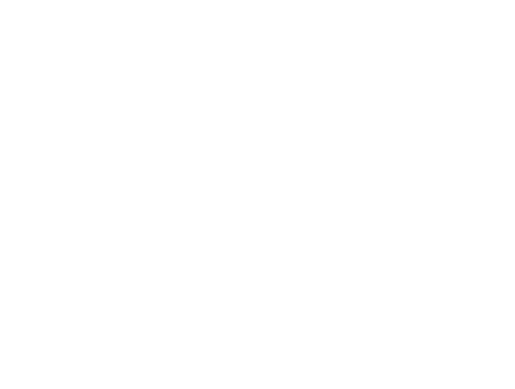

In [4]:
# Create a figure and axis
fig, ax = plt.subplots()
ax.axis('off')
original_image = image_resized.copy()
image_rotated = original_image.copy()
image_plot = ax.imshow(image_rotated, cmap='gray')

# Animation function
def animate(frame):
    global image_rotated
    if frame > 0:
        image_rotated = rotate_image_splineops(image_rotated, 5, order=order)  # Rotate by 5 degrees each frame
    image_plot.set_data(image_rotated)
    return [image_plot]

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=73, interval=50, blit=True)
plt.close(fig)  # Prevents the initial still image from displaying
display(HTML(ani.to_jshtml()))